# Сегментация пользователей банка по потреблению

В нашем распоряжении данные о клиентах банка "Метанпромбанк". Банк находится в трех городах: Ярославль, Рыбинск и Ростов Великий. Необходимо на основании имеющихся данных провести сегментацию, составить портреты потребителей, сформулировать и проверить статистические гипотезы и сформулировать предложения, которые помогут сократить отток клиентов в каждом сегменте.

Цель работы: предложить клиентам из разных сегментов услуги банка, которые помогут уменьшить отток.
<br> Задача: Сегментировать пользователей по количеству продуктов, которыми они пользуются

Ссылка на презентацию
https://cloud.mail.ru/public/b4mX/e8M1gsqtA

## Общее ознакомление с данными
- Описание источника данных
- Формулирование цели и задачи исследования
- Загрузка библиотек
- Загрузка исходных данных
- Обзор датасета

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams
import matplotlib.patches as mpatches
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    data = pd.read_csv('bank_dataset.csv')
except:
    data = pd.read_csv('datasets/bank_dataset.csv')

Посмотрим на общую информацию о датасете

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [4]:
data.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


### Общая информация о датасете
Перед нами выгрузка в 10 тыс. строк с довольно большим количеством пропусков в данных о балансе счета. В остальном данные выглядят хорошо, в других столбцах пропусков нет, тип данных соответствует описанию.

## Предобработка
- Проверка на пропуски и заполнение пропусков
- Проверка на дубликаты и исправление дубликатов
- Проверка на выбросы и удаление выбросов
- Добавление вспомогательных столбцов
- Формулирование выводов о качестве исходных данных

### Переименование столбцов
Необходимо переименовать столбцы, чтобы они соответствовали правилам хорошего стиля

In [5]:
data.columns = data.columns.str.lower()
data.rename({'userid': 'user_id',
             'creditcard': 'credit_card'
            }, axis=1, inplace=True)

### Проверка дубликатов 
Теперь посмотрим, есть ли в данные полные дубликаты

In [6]:
data.duplicated().sum()

0

Дубликатов нет. Посмотрим, как отображены категориальные данные, нет ли скрытых дубликатов

In [7]:
display(data.city.unique())
display(data.gender.unique())
display(data.credit_card.unique())
display(data.loyalty.unique())
display(data.churn.unique())

array(['Ярославль', 'Рыбинск', 'Ростов Великий'], dtype=object)

array(['Ж', 'М'], dtype=object)

array([1, 0], dtype=int64)

array([1, 0], dtype=int64)

array([1, 0], dtype=int64)

Скрытых дубликатов нет. 
### Оценка выбросов
Посмотрим на числовые данные.

In [8]:
data.describe()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


- score - баллы кредитного скоринга. Минимальное значение 350, максимальное  850
- age - возраст клиента. Минимальное значение 18, максимальное - 92. Все в пределах логики.
- objects -  количество объектов в собственности. Минимум - 0, максимум - 10.
- balance - баланс на счёте. Минимальное значение 3768, максимум - 250898.09
- products - количество продуктов, которыми пользуется клиент. Минимальное значение - 1, максимальное - 4.
- estimated_salary - заработная плата клиента. Минимальное значение - 11.58, максимальное - 199992.48
<br> Единственное значение, которое стоит проверить, это минимальная зарплата. Все остальное выглядит правдоподобно.

In [9]:
data[data['estimated_salary']<13000]

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
16,15780188,653,Ростов Великий,М,58,1,132602.88,1,1,0,5097.67,1
23,15768473,669,Ярославль,М,46,3,NaN,2,0,1,8487.75,0
58,15666680,511,Рыбинск,Ж,66,4,NaN,1,1,0,1643.11,1
84,15781487,493,Ярославль,Ж,46,4,NaN,2,1,0,1907.66,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9943,15702231,784,Рыбинск,М,23,2,NaN,1,1,1,6847.73,0
9948,15777814,724,Ростов Великий,Ж,53,1,139687.66,2,1,1,12913.92,0
9954,15782586,645,Ярославль,М,45,6,155417.61,1,0,1,3449.22,0
9979,15735400,677,Ярославль,Ж,58,1,90022.85,1,0,1,2988.28,0


Есть подозрение, что данные по зарплате считаются по формуле, например на основании суммы приходов на счет с делением на период в месяцах, а не являются реальными данными о доходах. Возможно, таким образом банк пытается учесть доходы индивидуальных предпренимателей. Для людей, которые не получают зарплату на счет в этом банке, а время от времени получают переводы от знакомых, например, за совместный обед, сумма не является адекватной. Уберем из выборки данные ниже 13000 (такой на текущий момент размер МРОТ).

In [10]:
data = data[data['estimated_salary']>=13000]

### Заполнение пропусков
Посмотрим внимательнее на пропуски в стобце balance

In [11]:
balance_na = data[data['balance'].isna()]
balance_na

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
11,15779909,497,Рыбинск,М,24,3,NaN,2,1,0,76390.01,0
12,15675000,476,Ярославль,Ж,34,10,NaN,2,1,0,26260.98,0
13,15734219,549,Ярославль,Ж,25,5,NaN,2,0,0,190857.79,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9989,15648358,841,Рыбинск,М,28,4,NaN,2,1,1,179436.60,0
9992,15699841,726,Рыбинск,М,36,2,NaN,1,1,0,195192.40,0
9994,15762030,800,Ярославль,Ж,29,2,NaN,2,0,0,167773.55,0
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0


Посмотрим, каким образом пропуски распределены между клиентами, которые ушли и теми, кто продолжает пользоваться услугами банка

In [12]:
balance_na.pivot_table(index='churn', values='user_id', aggfunc='count').reset_index().sort_values(by='user_id', ascending=False)

,churn,user_id
0,0,2880
1,1,470


Только 470 из 2880 клиентов без данных о балансе перестали пользоваться услугами. Дело явно не в этом признаке. Посмотрим, как данные распределены по городам и между лояльными и нелояльными клиентами.

In [13]:
balance_na.pivot_table(index='city', columns='loyalty', values='user_id', aggfunc='count').reset_index()

loyalty,city,0,1
0,Рыбинск,548,560
1,Ярославль,1073,1169


В Ростове Великом нет клиентов с пропусками в данных о балансе, но происходение пропусков этот факт не объясляет. По лояльным и нелояльным клиентам данные распределены равномерно.

In [14]:
balance_na.pivot_table(index='gender', columns='credit_card', values='user_id', aggfunc='count').reset_index()

credit_card,gender,0,1
0,Ж,435,1096
1,М,513,1306


В данных с пропусками есть клиенты обоих полов, вне зависимости от того, пользуются ли они кредитной картой. Эти факторы тоже не коррелируют с причиной пропусков. Посмотрим, есть ли корреляция по количеству объектов и количеству продуктов.

In [15]:
balance_na.pivot_table(index='objects', columns='products', values='user_id', aggfunc='count').reset_index()

products,objects,1,2,3,4
0,0,42.0,83.0,2.0,NaN
1,1,87.0,211.0,15.0,1.0
2,2,85.0,254.0,9.0,4.0
3,3,83.0,227.0,11.0,1.0
4,4,88.0,236.0,10.0,1.0
5,5,83.0,254.0,10.0,2.0
6,6,89.0,253.0,5.0,NaN
7,7,81.0,269.0,6.0,NaN
8,8,83.0,254.0,8.0,NaN
9,9,90.0,233.0,8.0,3.0


Клиенты, у которых в залоге 0 или 10 объектов, реже других попадают в выборку. К сожалению, данных недостаточно, чтобы сделать предположение о взаимосвязи этого фактора с отсутствием данных о балансе. Также мы видим, что отсутствуют клиенты с 4 продуктами и некоторым количеством объектов в залоге. Но клиенты с 4 продуктами группа в принципе очень малочисленная, такие клиенты там могут отсутствовать вообще.

Единственная явная закономерность, которую удалось обнаружить - такие клиенты отсутствуют в Ростове Великом. По остальным категоориям данные с пропусками распределены более-менне равномерно. Видимо, данные не подгрузились в связи с технической ошибкой. Попробуем заполнить пропуски на основании медианных данных по группам.

Добавим несколько вспомогательных столбцов. 
<br> Объеденим клиентов в возрастные группы по следующему принципу:
- 18-35 - young
- 36-59 - middle-aged
- 60 и старше - elderly

In [16]:
def age_group(row):
    age = row
    if age <= 35:
        return 'young'
    if 35 < age <= 60:
        return 'middle-aged'
    return 'elderly'

data['age_group'] = data['age'].apply(age_group)

Объединим клиентов в группы по доходу по следующему принципу:
- ниже 50000 - D
- 50 - 100 тыс - C
- 100 - 150 тыс - B
- более 150 тыс - A

In [17]:
def income_group(row):
    estimated_salary = row
    if estimated_salary <= 50000:
        return 'D'
    if 50000 < estimated_salary <= 100000:
        return 'C'
    if 100000 < estimated_salary <= 150000:
        return 'B'
    return 'A'

data['income_group'] = data['estimated_salary'].apply(income_group)

Для того, чтобы корретно разделить клиентов по баллам кредитного скоринга, посмотрим, как баллы скоринга коррелируют с наличием кредитных карт и количеством залогового имущества.

In [18]:
data.pivot_table(index='objects', columns='credit_card', values='score', aggfunc='median').reset_index()

credit_card,objects,0,1
0,0,662.0,647.0
1,1,646.0,654.5
2,2,661.0,653.0
3,3,656.0,649.0
4,4,651.0,652.0
5,5,657.5,654.0
6,6,652.0,645.0
7,7,657.0,650.0
8,8,646.0,650.0
9,9,662.0,655.0


Значительной разницы между группами не выявлено.
Объединим клиентов в группы по баллам кредитного скоринга по следующему принципу:
- менее 450 - low
- 451 - 550 - lower-middle
- 551 - 650 - middle
- 651 - 750 - upper-middle
- более 750 - hight

In [19]:
def score_group(row):
    score = row
    if score <= 450:
        return 'low'
    if 451 < score <= 550:
        return 'lower-middle'
    if 551 < score <= 650:
        return 'middle'
    if 651 < score <= 750:
        return 'upper-middle'
    return 'hight'

data['score_group'] = data['score'].apply(score_group)

Заполним пропуски в данных о балансе медианными значениями по группам. Для формирования групп будем использовать данные о том, к какой группе клиент относится по возрасту, полу, доходам и баллам кредитного скоринга.

In [20]:
data['index']=data['gender']+data['age_group']+data['income_group']+data['score_group'] #создаем вспомогательный столбец

median_balance = data.groupby('index')['balance'].agg('median') #заполняем пропуски медианными значениями для каждой группы
    
for row in median_balance.index:
    data.loc[(data['index']==row) & (data['balance'].isna()), 'balance'] = median_balance[row]

data = data.drop('index', axis=1) #удаляем вспомогательный столбец

Поскольку отсутствует приблизительно 30% данных об остатке на счете, заполнение медианными значениями сильно "усреднит" выборку. Я не считаю это критичным в данной ситуации, поскольку остаток на счете довольно гибкая величина и может быстро меняться. Нам для анализа важно понимать, сколько денег может быть на остатке у людей из разных групп.

### Кодирование данных
Для того, чтобы сделать графики более понятными, закодируем некоторые признаки

In [21]:
data['credit_card'] = np.where(data['credit_card'] == 1, 'yes', 'no')
data['loyalty'] = np.where(data['loyalty'] == 1, 'loyal', 'not loyal')
data['churn'] = np.where(data['churn'] == 1, 'left', 'active')

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9350 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           9350 non-null   int64  
 1   score             9350 non-null   int64  
 2   city              9350 non-null   object 
 3   gender            9350 non-null   object 
 4   age               9350 non-null   int64  
 5   objects           9350 non-null   int64  
 6   balance           9350 non-null   float64
 7   products          9350 non-null   int64  
 8   credit_card       9350 non-null   object 
 9   loyalty           9350 non-null   object 
 10  estimated_salary  9350 non-null   float64
 11  churn             9350 non-null   object 
 12  age_group         9350 non-null   object 
 13  income_group      9350 non-null   object 
 14  score_group       9350 non-null   object 
dtypes: float64(2), int64(5), object(8)
memory usage: 1.1+ MB


Посмотрим, какую часть данных мы отсекли в процессе предобработки.

In [23]:
display(f'Мы потеряли {((10000-len(data.user_id))/10000):.2%} данных')

'Мы потеряли 6.50% данных'

### Вывод
Проведя предобработку, можно сказать, что данные собираются доволько аккуратно. Значительных выбросов и дубликатов не обнаружено. Есть проблема с отсутствием данных о балансе на счете, которая касается значительного количества данных. При возможности, стоит обратить на это внимание. Также есть неправдоподобно низкие данные о доходах, которые не соответствуют действительности.

## Исследовательский анализ данных
- Проверка корреляции признаков
- Проверка диапазонов, в которых лежат числовые признаки
- Построение графиков и описание данных
- Формулирование выводов о взаимосвязи критериев

Мы будем проводить исследовательский анализ исходя из общей задачи работы. Нам необходимо выяснить, как разные критерии, представленные в данных, коррелируют с оттоком клиентов. 

Посмотрим на матрицу корреляций. Чтобы увидеть, связь критериев с категориальными показателями, закодируем названия городов и другие признаки, чтобы они тоже были отражены в матрице.

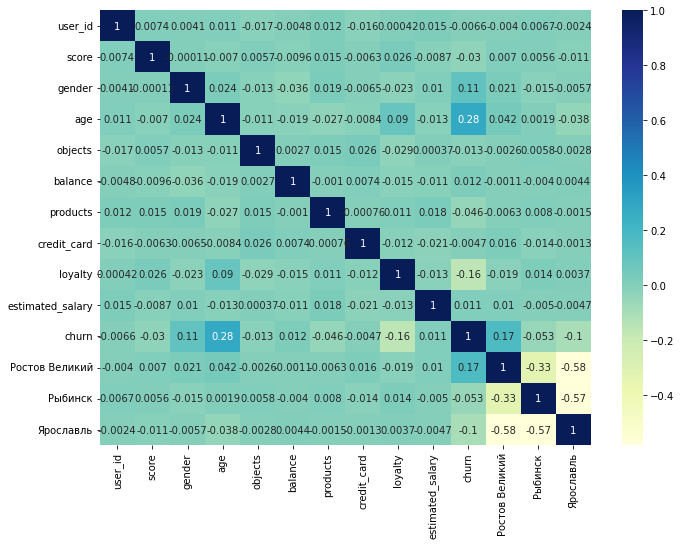

In [24]:
city_dummies = pd.get_dummies(data.city)
d1 = pd.concat([data, city_dummies], axis=1)

d1['credit_card'] = np.where(data['credit_card'] == 'yes', 1, 0)
d1['loyalty'] = np.where(data['loyalty'] == 'loyal', 1, 0)
d1['churn'] = np.where(data['churn'] == 'left', 1, 0)
d1['gender'] = np.where(data['gender'] == 'Ж', 1, 0)

corr = d1.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="YlGnBu",annot=True)
plt.show()

Между критериями нет высокой корреляции, все критерии связаны между собой слабо. Тем не менее, стоит отметить связь оттока с такими критериями, как пол, возраст и проживание в городе Ростов Великий. Также при дальнейшем анализе стоит обратить внимание на связь возраста и лояльности.

Посмотрим на разброс данных об остатках на счетах клиентов с разбивкой по разным критериям

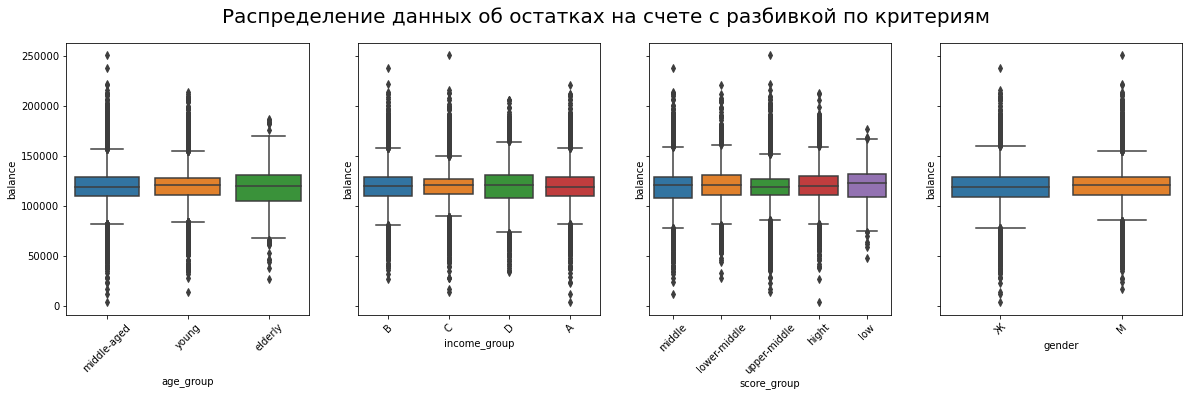

In [25]:
features=['age_group','income_group','score_group','gender']
n=0

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.suptitle('Распределение данных об остатках на счете с разбивкой по критериям', fontsize=(20))
for i in features:
    an = sns.boxplot(ax=axes[n], data=data, x=i, y='balance').tick_params(axis='x', rotation=45)
    n = n+1

plt.show()

На графике мы видим большое количество выбросов. Медианные значения у всех групп примерно одинаковые, но нужно будет взглянуть на них поближе.
<br> При разбивке на возрастные группы самый большой разброс данных в группе среднего возраста. Экстремумы наблюдаются как в большую, так и в меньшую стороны. Наименьший разброс наблюдается у пожилых клиентов.
<br> При разбивке по доходам более значительный разбров в обеспеченных группах A и B, наименьший - в группе с наименьшим доходом.
<br> Для группировки по баллам кредитного скоринга просматривается та же тенденция. Наименьшее количество выбросов в группе с низким рейтингом, наибольшее - в группе "выше среднего". 
<br> При разбивке клиентов по полу можно увидеть, что у женщин больше выбросов в меньшую сторону, а у мужчин - в большую.
<br> Посмотрим на те же данные приблизив 

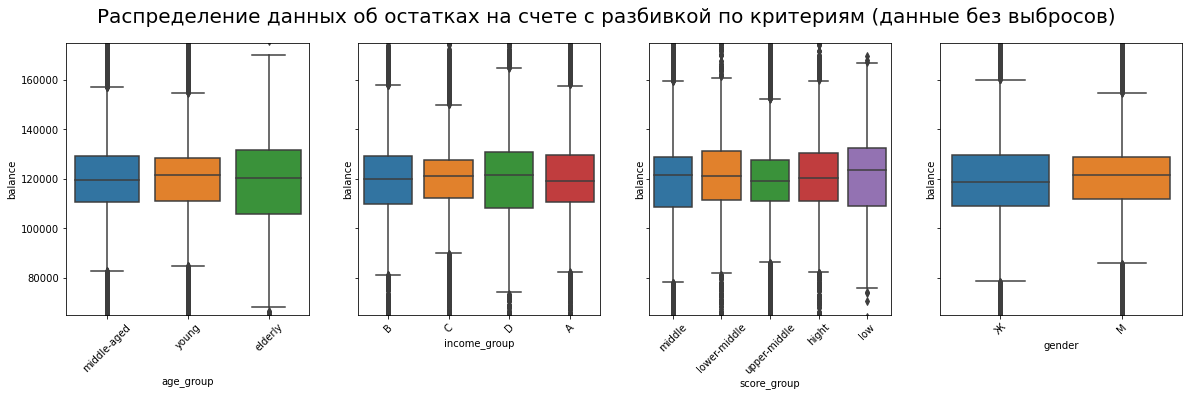

In [26]:
n=0
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.suptitle('Распределение данных об остатках на счете с разбивкой по критериям (данные без выбросов)', fontsize=(20))
for i in features:
    an = sns.boxplot(ax=axes[n], data=data, x=i, y='balance').tick_params(axis='x', rotation=45)
    n = n+1
plt.ylim(65000, 175000)
plt.show()

На графиках видно, что медианный остаток на счете для всех групп находится в районе 120000 и различается незначительно. Любопытно, что наибольший медианный остаток в разрезе по возрастам имеет молодая группа, по доходу - группа с самым низким доходом, по кредитному рейтингу - группа с самым низким кредитным рейтингом. Возможно, в нашем банке недостаточно выгодные условия для хранения денег на счете по сравнению с конкурентами, и обеспеченные клиенты предпочитают хранить деньги там, где больше процент на остаток или еще какие-то интересные условия.

Посмотрим, как меняется медианный размер остатка на счете в зависимости от возрастной группы и группы кредитного скоринга.

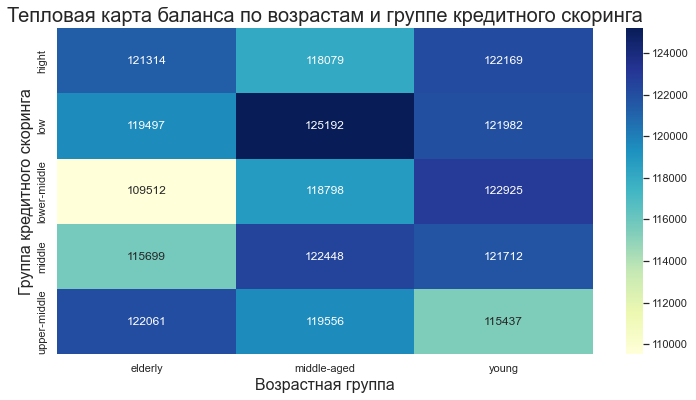

In [27]:
a = data.pivot_table(index='score_group', columns='age_group', values='balance', aggfunc='median')
sns.set(rc = {'figure.figsize':(12,6)})
sns.heatmap(a, annot=True, fmt='0.0f', cmap="YlGnBu")
plt.title('Тепловая карта баланса по возрастам и группе кредитного скоринга', fontsize=20)
plt.ylabel('Группа кредитного скоринга', fontsize=16)
plt.xlabel('Возрастная группа', fontsize=16)
plt.show()

Прямой зависимости между возрастом, крудитным рейтингом и остатком на счете не наблюдается. Любопытно, что самый  высокий медианный баланс в группе людей среднего возраста с низким рейтингом. Возможно,  это малочисленная группа, куда попал любитель копить остаток на счете. Самый низкий остаток - у пожилых людей с рейтингом ниже среднего. Посмотрим на аналогичные данные по доходу.

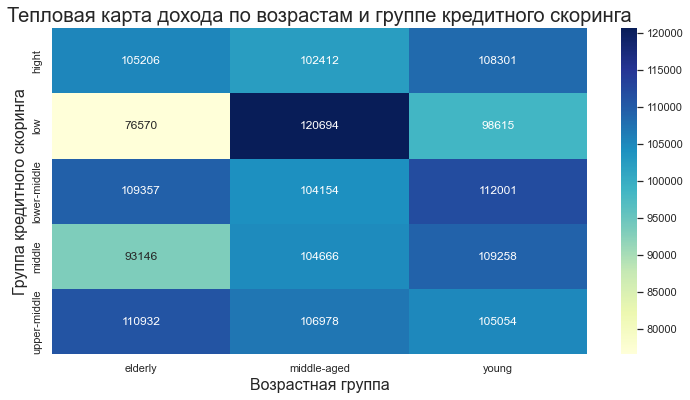

In [28]:
a = data.pivot_table(index='score_group', columns='age_group', values='estimated_salary', aggfunc='median')
sns.set(rc = {'figure.figsize':(12,6)})
sns.heatmap(a, annot=True, fmt='0.0f', cmap="YlGnBu")
plt.title('Тепловая карта дохода по возрастам и группе кредитного скоринга', fontsize=20)
plt.ylabel('Группа кредитного скоринга', fontsize=16)
plt.xlabel('Возрастная группа', fontsize=16)
plt.show()

По максимальному медианному доходу опять выделилась группа низкий рейтинг - средний возраст. Вероятно,  туда попал человек с высоким доходом и плохой кредитной историей, который сильно влияет на медиану. Самый низкий доход - в группе низкий ретинг - пожилой возраст. Медианный доход распределен по группам довольно равномерно.

Посмотрим на отток клиентов по городам

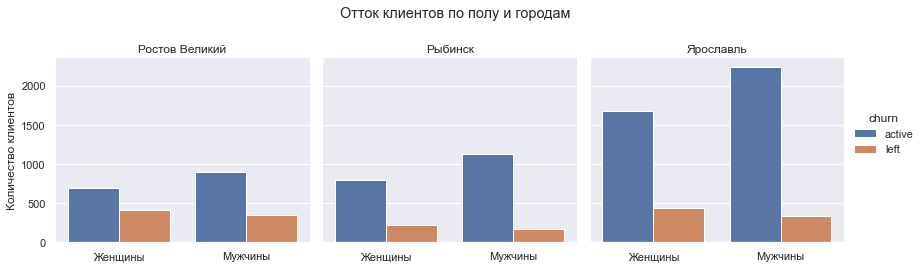

In [29]:
d1 = (data
      .pivot_table(index=['gender','churn','city'], values='user_id', aggfunc='count')
      .reset_index()
     )

a = sns.catplot(x="gender", y="user_id", hue="churn", col="city", data=d1, kind="bar", height=4, aspect=1)

a.set_axis_labels("", "Количество клиентов")
a.set_xticklabels(["Женщины", "Мужчины"])
a.set_titles("{col_name}")
a.fig.subplots_adjust(top=0.8)
a.fig.suptitle('Отток клиентов по полу и городам')
plt.show()

Самая большая доля в оттоке клиентов наблюдается в Ростове Великом. Также видно, что женщин во всех городах уходит больше, чем мужчин.

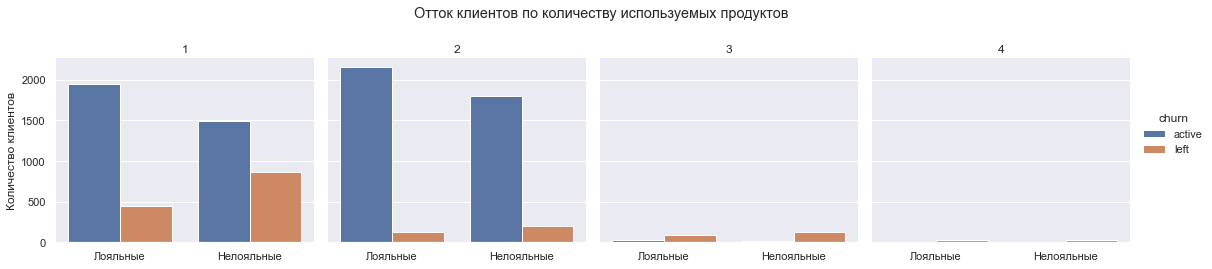

In [30]:
d1 = (data
      .pivot_table(index=['loyalty','churn','products'], values='user_id', aggfunc='count')
      .reset_index()
     )

a = sns.catplot(x="loyalty", y="user_id", hue="churn", col="products", data=d1, kind="bar", height=4, aspect=1)

a.set_axis_labels("", "Количество клиентов")
a.set_xticklabels(["Лояльные", "Нелояльные"])
a.set_titles("{col_name}")
a.fig.subplots_adjust(top=0.8)
a.fig.suptitle('Отток клиентов по количеству используемых продуктов')
plt.show()

Клиенты, использующие 2 продукта - самая многочисленная группа. Количество лояльных и нелояльных клиентов в этой группе сопоставимо, но отток достаточно низкий. Отток у использующих один продукт значительно выше, чем в группе, использующей 2 продукта. Клиентов, использующих 3 и 4 продукта значительно меньше, чем тех, кто пользуется одним или двумя, но тут намечается другая закономерность: нелояльных клиентов значительно больше, чем лояльных и ушедших клиентов больше, чем активных. Возможно, использование более, чем двух продуктов, чаще всего подразумевает несколько кредитов, и люди, закрыв их, перестают пользоваться услугами банка.

Посмотрим на аналогичные данные в разрезе групп кредитного скоринга.

In [31]:
# Напишем формулу для построения графиков с долей оттока
def percent_bar(group, title, xlabel):
    plt.figure(figsize=(6, 6))
    #Расчитаем долю активных пользователей
    total = data.groupby(group)['user_id'].count().reset_index()
    active = data[data.churn=='active'].groupby(group)['user_id'].count().reset_index()
    active['user_id'] = [i / j * 100 for i,j in zip(active['user_id'], total['user_id'])]
    total['user_id'] = [i / j * 100 for i,j in zip(total['user_id'], total['user_id'])]
    #Построим на одном графике 100% пользователей и долю активных
    bar1 = sns.barplot(x=group,  y="user_id", data=total, color='darkblue')
    bar2 = sns.barplot(x=group, y="user_id", data=active, color='lightblue')
    #Настроим легенду, подписи осей и название
    top_bar = mpatches.Patch(color='darkblue', label='left')
    bottom_bar = mpatches.Patch(color='lightblue', label='active')
    plt.legend(handles=[top_bar, bottom_bar], bbox_to_anchor=(1, 1), ncol=2)
    plt.title(title, fontsize=20)
    plt.ylabel('Доля клиентов, %', fontsize=16)
    plt.xlabel(xlabel, fontsize=16)

    plt.show()


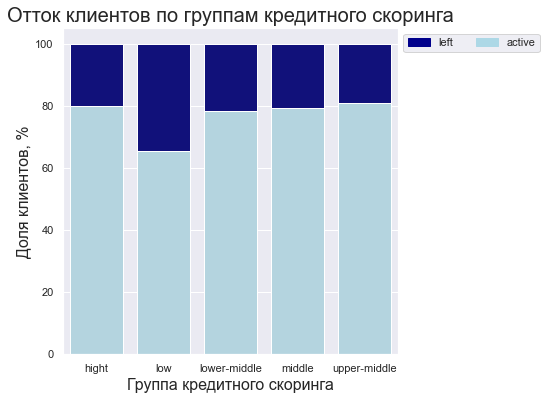

In [32]:
percent_bar('score_group', 'Отток клиентов по группам кредитного скоринга', 'Группа кредитного скоринга')

Самая большая доля оттока среди клиентов с низким рейтингом - более 30%. Вероятно, такие клиенты наименее ценны для банка, поэтому их не стараются задержать. В остальных группах показатель находится в районе 20%, для группы "ниже среднего" он чуть больше, чем в остальных группах.
<br> Посмотрим на данные в разрезе возрастных групп

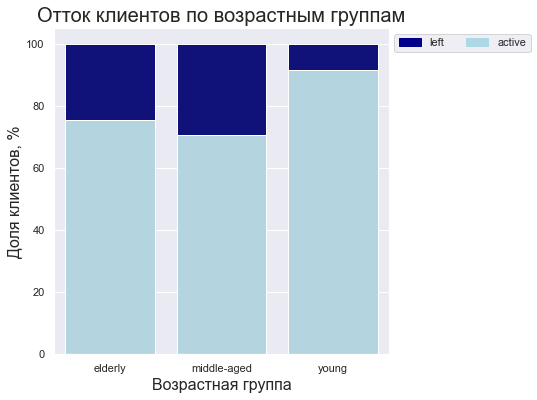

In [33]:
percent_bar('age_group', 'Отток клиентов по возрастным группам', 'Возрастная группа')

Наибольший отток - около 70% наблюдается в средней возрастной группе. Среди молодых клиентов отток самый низкий - менее 10%

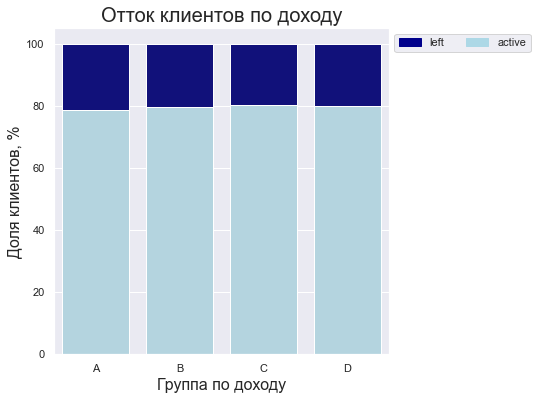

In [34]:
percent_bar('income_group', 'Отток клиентов по доходу', 'Группа по доходу')

Во всех группах по доходу примерно одинаковый отток клиентов - в районе 20%. Следовательно, уровень дохода мало вляет на решение перестать пользоваться услугами банка. 
<br> Посмотрим, как на отток влияет наличие кредитной карты.

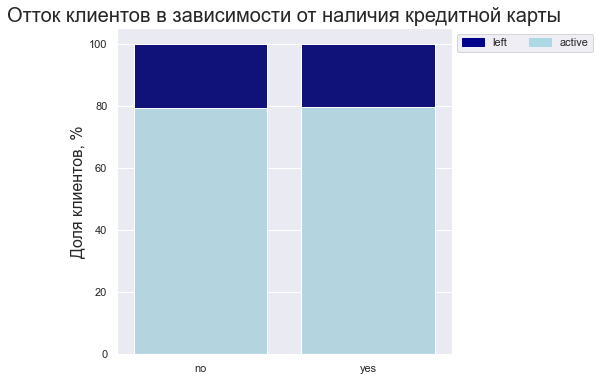

In [35]:
percent_bar('credit_card', 'Отток клиентов в зависимости от наличия кредитной карты', '')

Владельцы кредитных карт перестают пользоваться услугами банка также часто, как те, у кого их нет. Показатель оттока у обеих групп находится в районе 20%.
<br> Посмотрим, как распределяется отток в зависимости от количества заложенного имущества.

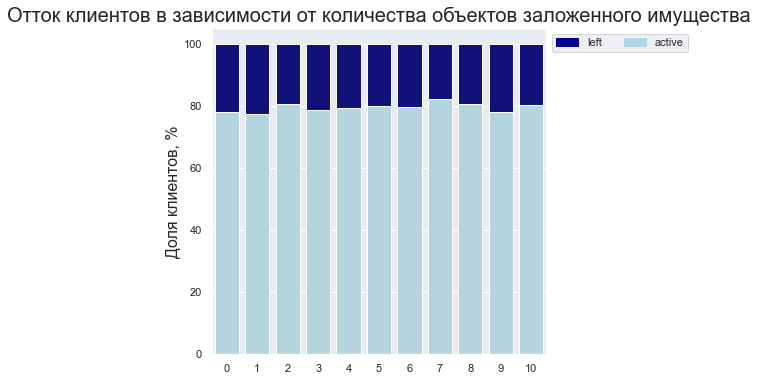

In [36]:
percent_bar('objects', 'Отток клиентов в зависимости от количества объектов заложенного имущества', '')

Количество заложенных объектов также не является критерием, который влияет на отток клиентов.

### Вывод
Средний показатель оттока клиентов - 20%
<br> Среди критериев, которые влияют на отток клиентов из банка, наиболее значительными являются возраст, пол, место жительства. 
<br> В Ростове Великом показатель оттока значительно выше, чем в других городах - более 30%. Возможно, этот факт требует дополнительного изучения.
<br> В разрезе по полу женщины уходят активнее, чем мужчины: 25% против 17.
<br> В разрезе по возрастным группам низкий показатель у молодых пользователей - 8%. А пользователи среднего возраста уходят очень активно - почти 30%.
<br> Исследовательский анализ показал, что среди клиентов, использующих более двух продуктов (это небольшая доля клиентов) значительно растет число нелояльных клиентов и увеличивается отток. Среди тех, кто пользовался тремя продуктами банка, ушли 83%. Среди пользовавшихся 4-мя продуктами на момент анализа в базе не было ни одного активного клиента. Возможно, такой высокий отток связан с тем, что люди закрыли свои кредиты и больше не хотят пользоваться услугами банка, но стоит убедиться, что причиной не являются технические проблемы, связанные с большим количеством продуктов банка в приложении у клиента, которые сильно снижают качество оказываемых услуг.
<br> Показатели, связанные с банковской активностью, такие как наличие кредитной карты, количество объктов собственности в залоге, кредитный рейтинг, влияют на отток незначительно. 

## Сегментация
- Формулирование принципов сегментации
- Проведение сегментации
- Формулирование выводов о том, как данные распределены по сегментам

Проведем сегментацию пользователей по количеству используемых продуктов. Поскольку клиенты, использующие более двух продуктов являются подавляющим меньшинством и в их поведении наблюдаются похожие закономерности, считаю возможным создать три сегмента:
- использует 1 продукт (1)
- использует 2 продукта (2)
- использует 3 и более продуктов (3 and more)

In [37]:
def segment(row):
    products = row
    if products > 2:
        return '3 and more'
    return products

data['segment'] = data['products'].apply(segment)

Посмотрим, какую долю занимает каждый сегмент в общей базе клиентов

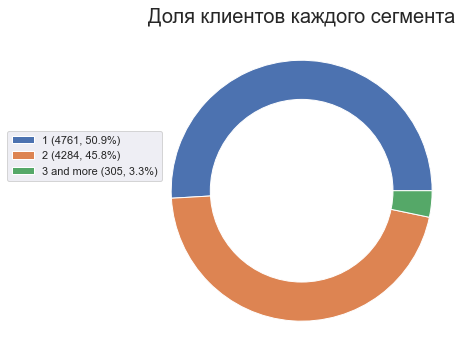

In [38]:
a = data.pivot_table(index='segment', values='user_id', aggfunc='count').reset_index()
names=a['segment']
val=a['user_id']
total=sum(val)
labels=[f"{n} ({v}, {v/total:.1%})" for n,v in zip(names, val)]

size_of_groups=a['user_id']
plt.pie(size_of_groups)
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.legend(
    bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25),
    loc = 'best', labels = labels )
plt.title('Доля клиентов каждого сегмента', fontsize=20)
plt.show()

Клиенты, использующие 3 продукта и более в абсолютном меньшинстве - всего 3%. Больше всего людей пользуются только одним продуктом. Посмотрим, как выглядит доля оттока в каждом сегменте

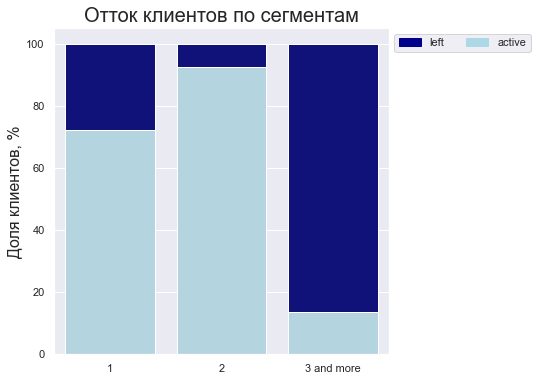

In [39]:
percent_bar('segment', 'Отток клиентов по сегментам', '')

В сегменте "3 and more" отток превышает 80%. Мы уже обращали на это внимание в ходе исследовательского анализа данных. Но и в сегменте, использующем один продукт тоже большой отток - почти 30%. У клиентов, использующих 2 продукта, отток небольшой - менее 10%. Посмотрим на лояльность клиентов по сегментам.

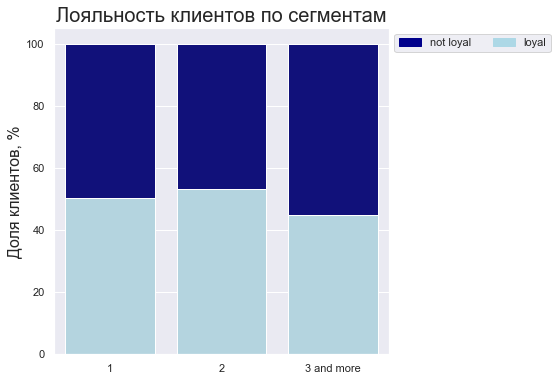

In [40]:
plt.figure(figsize=(6, 6))
    
total = data.groupby('segment')['user_id'].count().reset_index()
loyal = data[data.loyalty=='loyal'].groupby('segment')['user_id'].count().reset_index()
loyal['user_id'] = [i / j * 100 for i,j in zip(loyal['user_id'], total['user_id'])]
total['user_id'] = [i / j * 100 for i,j in zip(total['user_id'], total['user_id'])]
    
bar1 = sns.barplot(x='segment',  y="user_id", data=total, color='darkblue')
bar2 = sns.barplot(x='segment', y="user_id", data=loyal, color='lightblue')
    
top_bar = mpatches.Patch(color='darkblue', label='not loyal')
bottom_bar = mpatches.Patch(color='lightblue', label='loyal')
plt.legend(handles=[top_bar, bottom_bar], bbox_to_anchor=(1, 1), ncol=2)
plt.title('Лояльность клиентов по сегментам', fontsize=20)
plt.ylabel('Доля клиентов, %', fontsize=16)
plt.xlabel('', fontsize=16)

plt.show()

Лояльными являются около 50% клиентов в каждом сегменте. Среди использующих 2 продукта лояльность чуть выше, среди тех, кто использует три и более - чуть ниже среднего показателя. Посмотрим, как по сегментам распределены возрастные группы.

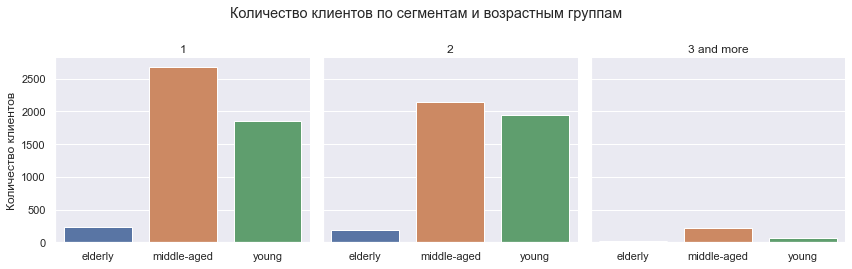

In [41]:
d1 = (data
      .pivot_table(index=['segment','age_group'], values='user_id', aggfunc='count')
      .reset_index()
     )

a = sns.catplot(x="age_group", y="user_id", col="segment", data=d1, kind="bar", height=4, aspect=1)

a.set_axis_labels("", "Количество клиентов")
a.set_xticklabels(d1.age_group.unique())
a.set_titles("{col_name}")
a.fig.subplots_adjust(top=0.8)
a.fig.suptitle('Количество клиентов по сегментам и возрастным группам')
plt.show()

Среди клиентов, использующих один продукт, людей среднего возраста значительно больше, чем представителей других групп. Среди использующих два продукта молодых почти столько же, сколько и клиентов среднего возраста (возможно, эти и объясняется лояльность сегмента, ведь молодые - самая лояльная аудитория нашего банка). В сегменте, использующем 3 и более продуктов, основная аудитория - клиенты среднего возраста, а пожилых почти нет.
<br> Посмотрим, как по сегментам распределены клиенты, использующие кредитные карты

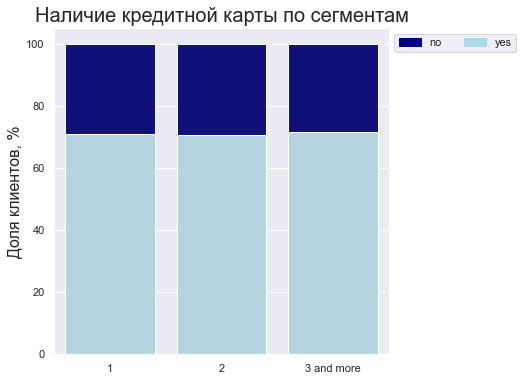

In [42]:
plt.figure(figsize=(6, 6))
    
total = data.groupby('segment')['user_id'].count().reset_index()
crcard = data[data.credit_card=='yes'].groupby('segment')['user_id'].count().reset_index()
crcard['user_id'] = [i / j * 100 for i,j in zip(crcard['user_id'], total['user_id'])]
total['user_id'] = [i / j * 100 for i,j in zip(total['user_id'], total['user_id'])]
    
bar1 = sns.barplot(x='segment',  y="user_id", data=total, color='darkblue')
bar2 = sns.barplot(x='segment', y="user_id", data=crcard, color='lightblue')
    
top_bar = mpatches.Patch(color='darkblue', label='no')
bottom_bar = mpatches.Patch(color='lightblue', label='yes')
plt.legend(handles=[top_bar, bottom_bar], bbox_to_anchor=(1, 1), ncol=2)
plt.title('Наличие кредитной карты по сегментам', fontsize=20)
plt.ylabel('Доля клиентов, %', fontsize=16)
plt.xlabel('', fontsize=16)

plt.show()

Около 70% клиентов банка используют кредитные карты вне зависимости от сегмента.

### Вывод
В процессе сегментации удалось выяснить, что самая значительная часть клиентов (51%) пользуется одним продуктом и только 3% клиентов пользуются более, чем 3-мя продуктами. 
<br> Самый низкий отток клиентов в сегменте, использующем 2 продукта, самый высокий - у клиентов, использующих 3 продукта и более.
<br> Около 50% клиентов лояльны банку, этот показатель примерно равен во всех сегментах (но у клиентов с 3 и более продуктами лояльность чуть ниже).
<br> Клиенты средней возрастной группы составляют большинство в каждом сегменте. Доля молодежи самая большая в сегменте, использующем 2 продукта.
<br> Доля клиентов, использующих кредитные карты, во всех сегментах примерно одинаковое и составляет большинство клиентов нашего банка (около 70%).

## Статистическое исследование
- Формулирование гипотез
- Статистическая проверка гипотез
- Формулирование вывода о верности гипотез

Нам необходимо проверить гипотезу различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним. Также нам необходимо самостоятельно сформулировать еще одну гипотезу и проверить ее.
<br> В качестве второй гипотезы проверим, являются ли обладатели кредитных карт и клиенты, у которых нет кредитной карты, одинаково лояльными банку.
<br> Для начала сформулируем нулевую и альтернативную гипотезу для первой задачи.

- H0 - Доход клиентов, которые использует один продукт не отличается от дохода клиентов, которые используют два продукта.
- H1 - Доход клиентов, которые использует один продукт отличается от дохода клиентов, которые используют два продукта.

Чтобы принять решение о том,  какой статистический инструмент использовать для проверки гипотез, проверим данные о доходах клиентов на нормальность, используя критерий Шапиро-Уилка.

In [43]:
alpha = 0.05

results = st.shapiro(data['estimated_salary'])
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')                                                                             

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


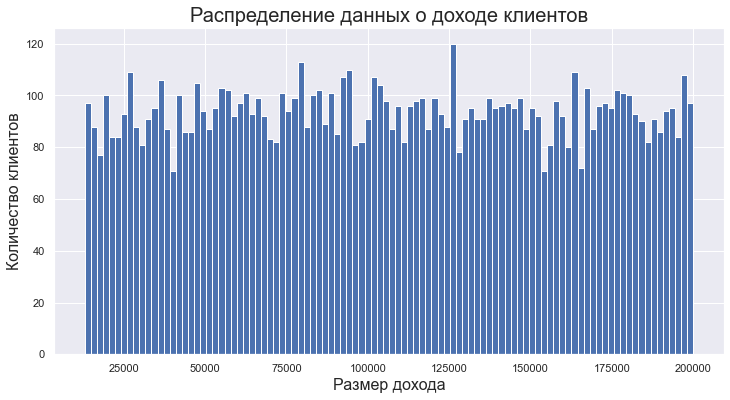

In [44]:
data['estimated_salary'].hist(bins=100)
plt.title('Распределение данных о доходе клиентов', fontsize=20)
plt.xlabel('Размер дохода', fontsize=16)
plt.ylabel('Количество клиентов', fontsize=16)
plt.show()

Поскольку данные распределены не нормально и содержат выбросы, для проверки гипотезы будем использовать критерий Манна-Уитни. Значение статистической значимости примем на уровне 0.05

In [45]:
income_1 = data['estimated_salary'][data['products']==1]
income_2 = data['estimated_salary'][data['products']==2]

alpha = 0.05

results = st.mannwhitneyu(income_1, income_2, True, 'less')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось опровергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-значение:  0.10979453245659582
Не получилось опровергнуть нулевую гипотезу, вывод о различии сделать нельзя


Нельзя считать, что доходы клиентов, которые пользуется одним продуктом статистически значимо отличаются от доходов тех, кто использует два продукта.

Для проверки второй гипотезы о лояльности клиентов с кредитной картой и без, сформулируем нулевую и альтернативную гипотезы:
- H0 - Лояльность клиентов с кредитными картами не отличается от лояльности клиентов без кредитных карт
- H1 - Лояльность клиентов с кредитными картами отличается от лояльности клиентов без кредитных карт

Поскольку данные являются бинарными, лучше всего подойдет proportion z-test. Значение статистической значимости примем на уровне 0.05

In [46]:
groups = data.pivot_table(index='credit_card', columns='loyalty', values='user_id', aggfunc='nunique').reset_index()

cr_card = groups['loyal'][1]
no_cr_card = groups['loyal'][0]
cr_card_size = data['user_id'][data['credit_card']=='yes'].nunique()
no_cr_card_size = data['user_id'][data['credit_card']=='no'].nunique()

alpha = 0.05

count = np.array([cr_card, no_cr_card]) 
nobs = np.array([cr_card_size, no_cr_card_size]) 
stat, pval = proportions_ztest(count, nobs)
print('p-value', '{0:0.3f}'.format(pval))
if pval < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось опровергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-value 0.231
Не получилось опровергнуть нулевую гипотезу, вывод о различии сделать нельзя


### Итоги статистического анализа
Мы проверили две гипотезы:
- Доход клиентов, которые использует один продукт не отличается от дохода клиентов, которые используют два продукта.
- Лояльность клиентов с кредитными картами не отличается от лояльности клиентов без кредитных карт
<br> Ни одну гипотезу не удалось опровергнуть. Нет оснований полагать, что доход клиентов, использующих один и два продукта, статистически значимо различается. Равно как и лояльность клиентов с кредитными картами и без оных.

## Общий вывод
- Обобщение информации о сегментации клиентов
- Предоставление рекомендаций по удержанию клиентов для каждого сегмента

Мы провели исследование данных, целью которого было изучить причины оттока клиентов из банка, сегментировать клиентов по количеству продуктов, которыми они пользуются и дать рекомендации для каждого сегмента с целью понижения оттока. 
<br> По результатам работы предложена следующая сегментация по количеству используемых продуктов:
- 1 продукт. Самое большое количество клиентов. Наша цель - предложить этой категории другие продукты и сделать клиента лояльным. Предложение: рассказывать в приложении банка про разные продукты, которыми клиент не пользуется. Предлагать попробовать на эксклюзивных условиях (повышенный кэшбек на 3 мес. или карта с лимитированным дизайном)
- 2 продукта. Клиенты с самым низким уровнем оттока. Предложение: Премиум-подписка с повышенным процентом на остаток по счету и приятными бонусами (например, повышенный кешбэк у партнеров, проход в бизнес-залы аэропортов, страхование в путешествии)
- 3 и более продуктов. Очень малочисленная группа с большим оттоком и низкой лояльностью. Предложение: отдельная линия поддержки с личным менеджером.
<br>
<br> Поскольку 70% клиентов используют кредитные карты вне зависимости от сегмента, рекомендуется также уделить особое внимание этому направлению. Работать над удобством пополнения счета и качеством поддержки, а также искать партнеров для спецпредложений. Можно разыгрывать билеты на мероприятия среди обладателей кредитных карт.